# ps

> persistent scatterers identification

In [ ]:
#| default_exp ps

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import zarr
from matplotlib import pyplot as plt
import colorcet
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import numpy as np
import math
import numba
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp

In [ ]:
#| export
# already robust enough for nan value
@numba.jit(nopython=True, cache=True,parallel=True)
def _amp_disp_numba(rslc):
    nlines, width, nimages = rslc.shape
    npixels = nlines*width
    rslc = rslc.reshape(npixels,nimages)
    amp_disp = np.empty(npixels,dtype=np.float32)
    for i in numba.prange(npixels):
        amp = np.abs(rslc[i,:])
        mean = np.mean(amp)
        std = np.std(amp)
        amp_disp[i] = std/mean
    return amp_disp.reshape(nlines,width)

In [ ]:
#| export
# already robust enough for nan value
if is_cuda_available():
    _amp_disp_kernel = cp.ElementwiseKernel(
        'raw T rmli_stack, int32 nlines, int32 width, int32 nimages',
        'raw T amp_disp_stack',
        '''
        int k;
        float mean = 0;
        float f_nimages = nimages;
        for (k=0;k<nimages;k++) {
            mean += rmli_stack[i*nimages+k];
        }
        mean /= f_nimages;
        float std = 0;
        for (k=0;k<nimages;k++) {
            std += powf(rmli_stack[i*nimages+k]-mean,2);
        }
        std = sqrt(std/f_nimages);
        amp_disp_stack[i] = std/mean;
        ''',
        name = 'amp_disp_kernel',no_return=True)

In [ ]:
#| export
if is_cuda_available():
    def _amp_disp_cp(rslc):
        rmli = cp.abs(rslc)
        nlines,width,nimages = rmli.shape
        amp_disp = cp.empty((nlines,width),dtype=cp.float32)
        _amp_disp_kernel(rmli,cp.int32(nlines),cp.int32(width),cp.int32(nimages),
                         amp_disp,size=nlines*width,block_size=128)
        return amp_disp

In [ ]:
#| export
def amp_disp(rslc:np.ndarray, # rslc stack, 3D numpy array or cupy array
            )-> np.ndarray: # dispersion index, 2D numpy array or cupy array
    '''calculation the amplitude dispersion index from SLC stack.'''
    xp = get_array_module(rslc)
    if xp is np:
        return _amp_disp_numba(rslc)
    else:
        return _amp_disp_cp(rslc)

Using amplitude dispersion index (ADI) to identify persistent scatterers is first used in [@ferrettiPermanentScatterersSAR2001].

Usage:

In [ ]:
rslc = zarr.open('../CLI/raw/rslc.zarr/',mode='r')[:]
adi_cpu = amp_disp(rslc)
if is_cuda_available():
    rslc_gpu = cp.asarray(rslc)
    adi_gpu = amp_disp(rslc_gpu)
    np.testing.assert_array_almost_equal(adi_cpu,adi_gpu.get())

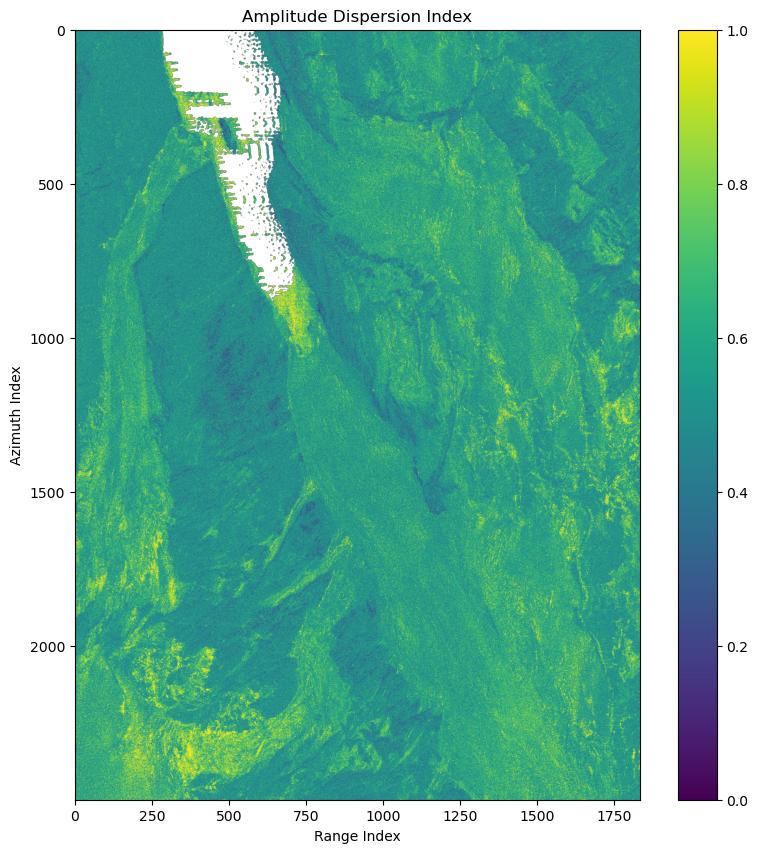

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(adi_cpu,vmin=0,vmax=1)
ax.set(title='Amplitude Dispersion Index',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()